# Анализируем вакансии Data Engineer используя HeadHunter

## Подключаем библиотеки, объявляем функции

In [ ]:
import json
from collections import namedtuple
from time import sleep

import pandas as pd
import requests


def get_vacation_props(vacation_id):
    """
    Возвращает требуемый стаж работы и навыки.
    """
    skills = []
    vacation_url = 'https://api.hh.ru/vacancies/'
    vacation_data = requests.get(url=(vacation_url + vacation_id)).json()
    sleep(1)  # Задержка, чтобы не ддосить api
    for skill in vacation_data['key_skills']:
        skills.append(skill['name'])
    return vacation_data['experience']['id'], skills if skills else ['Не указано']


def get_employer_industries(employer_id):
    """
    Возвращает отрасли деятельности работодателя.
    """
    industries = []
    employer_url = 'https://api.hh.ru/employers/'
    employer_data = requests.get(url=(employer_url + employer_id)).json()
    sleep(1)  # Задержка, чтобы не ддосить api
    for industry in employer_data['industries']:
        industries.append(industry['name'])
    return industries if industries else ['Не указано']

## Пользуясь API HeadHunter, достаем вакансии в словарь vacations
__!!! Долгая по времени операция !!!__

In [2]:
url = 'https://api.hh.ru/vacancies'
params = dict(
    text='name:(data and engineer) or name:(data and инженер) or name:(инженер and данных) or name:(engineer and данных)',
    area='113',  # Россия
    archived='false',  # Только действующие
    per_page='10',  # Указываю заведомо большее кол-во (заранее посмотрел сколько вернется)
)
data = requests.get(url=url, params=params).json()
Vacation = namedtuple("Vacation", "name employer_name employer_place industries experience skills")
vacations = []
for vacation in data['items']:
    vacation_prop = get_vacation_props(vacation['id'])
    vacations.append(
        Vacation(
            name=vacation['name'],
            employer_name=vacation['employer']['name'],
            employer_place=vacation['area']['name'],
            industries=get_employer_industries(vacation['employer']['id']),
            experience=vacation_prop[0],
            skills=vacation_prop[1]
        )
    )

## Формируем таблицу Pandas из полученных результатов

In [19]:
# with open('vacations.json', 'w', encoding='utf-8') as f:
#     json.dump(vacations, f)
# pd_vacations = pd.read_json(json.dumps(vacations))
# pd_vacations = pd.read_json('vacations.json')
pd_vacations = pd.read_json('https://disk.yandex.ru/d/2XsM_nKQh8W-Ow')
pd_vacations.columns = ["name", "employer_name", "employer_place", "industries", "experience", "skills"]
pd_vacations.head()

ValueError: Expected object or value

## Общее количество вакансий

In [11]:
len(vacations)

10

## Требуемый стаж работы по специальности

<AxesSubplot:>

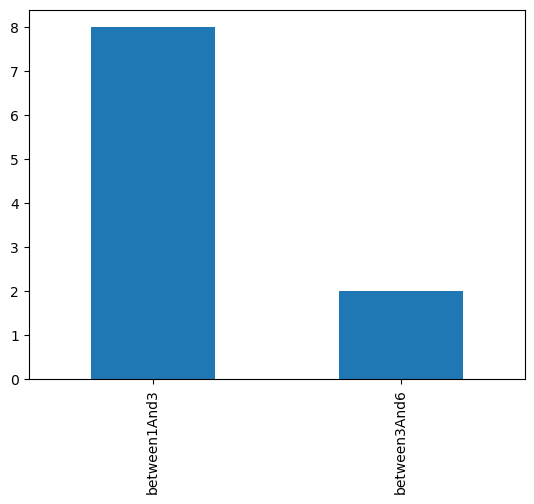

In [4]:
%matplotlib inline
experience_column = pd_vacations["experience"].apply(pd.Series)
experience_count = experience_column.iloc[:, 0].value_counts()
experience_count.plot(kind="bar")

## Требуемые навыки (10 наиболее востребованных)

<AxesSubplot:>

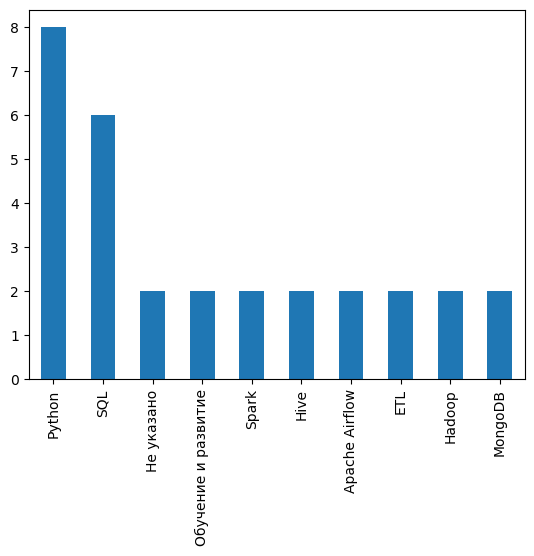

In [8]:
skills_column = pd_vacations["skills"].apply(pd.Series)
skills_count = skills_column.stack().value_counts()
skills_count[:10].plot(kind="bar")

## Распределение вакансий по городам (10 наиболее частых)

<AxesSubplot:>

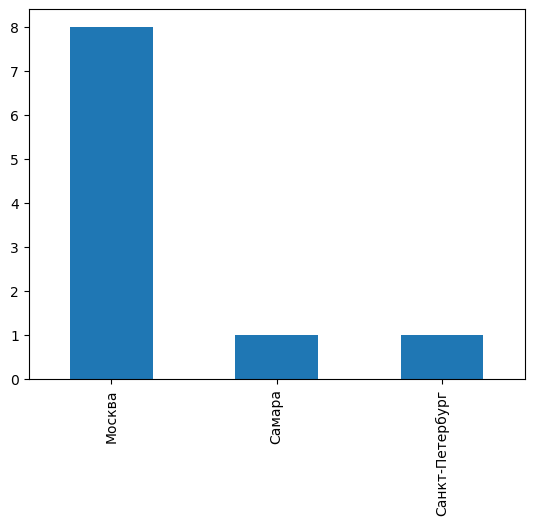

In [10]:
employer_place_column = pd_vacations["employer_place"].apply(pd.Series)
employer_place_count = employer_place_column.stack().value_counts()
employer_place_count[:10].plot(kind="bar")

## Распределение вакансий по отраслям (10 наиболее частых)

<AxesSubplot:>

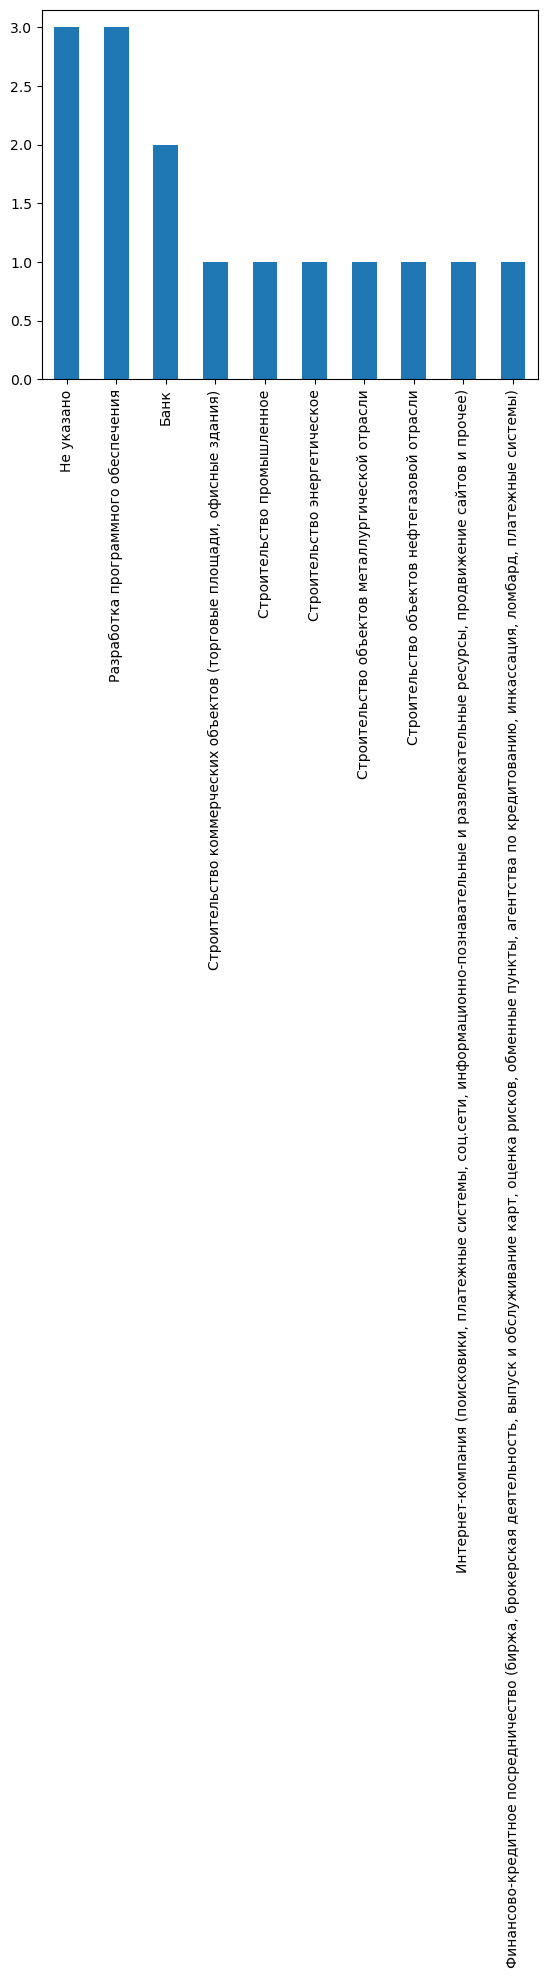

In [9]:
industries_column = pd_vacations["industries"].apply(pd.Series)
industries_count = industries_column.stack().value_counts()
industries_count[:10].plot(kind="bar")